# Exercices
You have 4 exercises in this lab assignment. First two are about ensemble models. Third is about decision trees and the last one, about creating a random forest from individual decision trees.

*Credits:* Based on [code written by A. Géron](https://github.com/ageron/handson-ml2) for his book ""Hands-on ML with scikit-learn, keras and tensorflow.", 2nd edition 2019, O'Reilly Media. Code realeased under [Apache-2.0 License](https://github.com/ageron/handson-ml2/blob/master/LICENSE).

In [64]:
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats


## Voting Classifier on MNIST
### Data
This exercise uses the MNIST dataset: a set of 28x28 images containing hadnwritten 0-9 digits. It can be loaded using `sklern` functions as follows:

In [65]:
from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

Here the feaures in X are simply all the 784 pixels of any given image, in vectorized form. To visualize the orignal image, the vector must be reshaped back to a 2D array as follows:

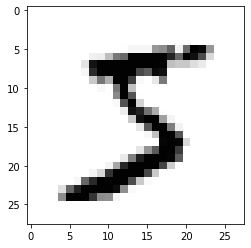

In [66]:
plt.imshow(X[0, :].reshape([28, 28]), cmap='Greys')

**The goal** is to correctly predict the digit from the image pixels. This is what you have in the y array:

In [67]:
y[0:10]

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4'], dtype=object)

### Feture range and scaling
In general, that pixel values here range in 0-255. However, since digits are always cented, pixels in the center of the image tend to have a larger variance than those at the border. To visualize this, observe the plotting of the stddev for each pixel across all images. See how pixels at the border have near 0 variance while  those at the center have a much large one.

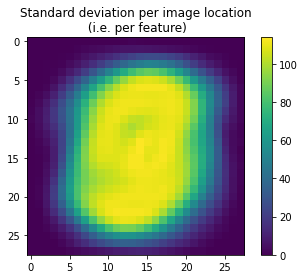

In [68]:
plt.imshow(X.std(axis=0).reshape([28,28]))
plt.colorbar()
plt.title("Standard deviation per image location\n (i.e. per feature)")
plt.show()

Remember models trained with continuous optimization (especially 1st order methods) benefit from features having a similar range (because this leads to better conditioned cost functions). For these methods **it is recommended that you apply some form of feature scaling**. For example, after applying standard scaling, variances become mostly equal to 1, meaning all features lie in a similar range:

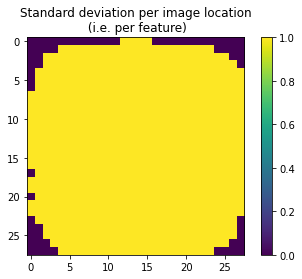

In [69]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

plt.imshow(X_scaled.std(axis=0).reshape([28,28]))
plt.colorbar()
plt.title("Standard deviation per image location\n (i.e. per feature)")
plt.show()

### Exercise

1. Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). 

1. Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM classifier. 

1. Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting.

1. Once you have found one, try it on the test set. 
 
1. How much better does it perform compared to the individual classifiers?

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [72]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [73]:
from sklearn.pipeline import make_pipeline

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = make_pipeline(StandardScaler(),
                         LinearSVC(max_iter=100, random_state=42))
mlp_clf = make_pipeline(StandardScaler(), 
                         MLPClassifier(random_state=42))

In [74]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(max_iter=100, random_state=42))])


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training the Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier', MLPClassifier(random_state=42))])


In [75]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.8811, 0.9747]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [76]:
from sklearn.ensemble import VotingClassifier

In [77]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [78]:
voting_clf = VotingClassifier(named_estimators)

In [79]:
voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('linearsvc',
                                               LinearSVC(max_iter=100,
                                                         random_state=42))])),
                             ('mlp_clf',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('mlpclassifier',
                                               MLPClassifier(random_state=42))]))])

In [80]:
voting_clf.score(X_val, y_val)

0.9721

In [81]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.0, 0.0, 0.0, 0.0]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this:

In [82]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('mlpclassifier',
                                               MLPClassifier(random_state=42))]))])

This updated the list of estimators:

In [83]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('mlpclassifier', MLPClassifier(random_state=42))]))]

However, it did not update the list of _trained_ estimators:

In [84]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('linearsvc', LinearSVC(max_iter=100, random_state=42))]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('mlpclassifier', MLPClassifier(random_state=42))])]

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [85]:
del voting_clf.estimators_[2]

Now let's evaluate the `VotingClassifier` again:

In [86]:
voting_clf.score(X_val, y_val)

0.9751

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [87]:
voting_clf.voting = "soft"

In [88]:
voting_clf.score(X_val, y_val)

0.9783

Nope, hard voting wins in this case.

_Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?_

In [89]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9717

In [90]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.0, 0.0, 0.0]

The voting classifier only very slightly reduced the error rate of the best model in this case.

## Stacking Ensemble on MNIST
1. Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image’s class.
1. Train a classifier on this new training set. 
1. Congratulations, you have just trained a blender, and together with the classifiers it forms a stacking ensemble! 
1. Now evaluate the ensemble on the test set. 
1. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble’s predictions.
1. How does it compare to the voting classifier you trained earlier?

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [91]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [92]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [93]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [94]:
rnd_forest_blender.oob_score_

0.9744

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [95]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [96]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [97]:
from sklearn.metrics import accuracy_score

In [98]:
accuracy_score(y_test, y_pred)

0.9715

This stacking ensemble does not perform as well as the voting classifier we trained earlier, it's not quite as good as the best individual classifier.

## (Optional) Train and fine-tune a decision tree
Train and fine-tune a Decision Tree for the moons dataset by following these steps:  
  1. Use `make_moons(n_samples=10000, noise=0.4)` to generate a moons dataset.   
  1. Use `train_test_split()` to split the dataset into a training set and a test set.
  1. Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.
  1. Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.

_Exercise: train and fine-tune a Decision Tree for the moons dataset._

a. Generate a moons dataset using `make_moons(n_samples=10000, noise=0.4)`.

Adding `random_state=42` to make this notebook's output constant:

In [99]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

b. Split it into a training set and a test set using `train_test_split()`.

In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c. Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [102]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

d. Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.

By default, `GridSearchCV` trains the best model found on the whole training set (you can change this by setting `refit=False`), so we don't need to do it again. We can simply evaluate the model's accuracy:

In [103]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

## (Optional) Grow your own random forest
Grow a forest by following these steps:  
  
  1. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. *Hint*: you can use ScikitLearn’s `ShuffleSplit` class for this.  
  1. Train one Decision Tree on each subset, using the best hyperparameter values found in the previous exercise. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.  
  1. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy’s mode() function for this). This approach gives you majority-vote predictions over the test set.  
  1. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher).   
  1. Congratulations, you have trained a Random Forest classifier!

_Exercise: Grow a forest._

a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn's `ShuffleSplit` class for this.

In [104]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

b. Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [105]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's `mode()` function for this). This gives you _majority-vote predictions_ over the test set.

In [106]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [107]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!

In [108]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872